In [1]:
# 导入必要的库
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 读取数据
file_path = 'churnnotclean.csv'
df = pd.read_csv(file_path)


In [2]:
# 检查是否存在 'ID' 列，若存在则删除
if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)

# 处理日期格式
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format='mixed', errors='coerce')
df['signup_date'] = pd.to_datetime(df['signup_date'], format='mixed', errors='coerce')

# 向前填充缺失值
df.fillna(method='ffill', inplace=True)

# 编码类别变量
label_encoder = LabelEncoder()
df['city'] = label_encoder.fit_transform(df['city'])
df['phone'] = label_encoder.fit_transform(df['phone'])

# 删除不需要的日期列
df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

# 处理缺失值，用平均值填充
imputer = SimpleImputer(strategy='mean')
df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
    'trips_in_first_30_days', 'weekday_pct']] = imputer.fit_transform(df[['avg_dist', 'avg_rating_by_driver', 
                                                                          'avg_rating_of_driver', 'avg_surge', 
                                                                          'surge_pct', 'trips_in_first_30_days', 
                                                                          'weekday_pct']])

C:\Users\DELL\AppData\Local\Temp\ipykernel_17892\2779944535.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [3]:

# 特征矩阵 X 和目标向量 y
X = df.drop(columns=['churn'])
y = df['churn']

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# 构建MLP神经网络模型
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)

# 进行模型预测
y_pred_class = mlp_model.predict(X_test)
y_pred_prob = mlp_model.predict_proba(X_test)[:, 1]

# 打印混淆矩阵
from sklearn.metrics import confusion_matrix
print(pd.DataFrame(confusion_matrix(y_test, y_pred_class), index=['true:0', 'true:1'], columns=['pred:0', 'pred:1']))


        pred:0  pred:1
true:0    2776    1944
true:1    1388    3892


In [5]:
# 评估模型：准确率、分类报告和ROC-AUC分数
accuracy = accuracy_score(y_test, y_pred_class)
classification_rep = classification_report(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)


In [6]:
# 打印评估结果
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)
print(f'ROC-AUC: {roc_auc:.4f}')

Accuracy: 0.6668
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.59      0.62      4720
           1       0.67      0.74      0.70      5280

    accuracy                           0.67     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.67      0.66     10000

ROC-AUC: 0.7123


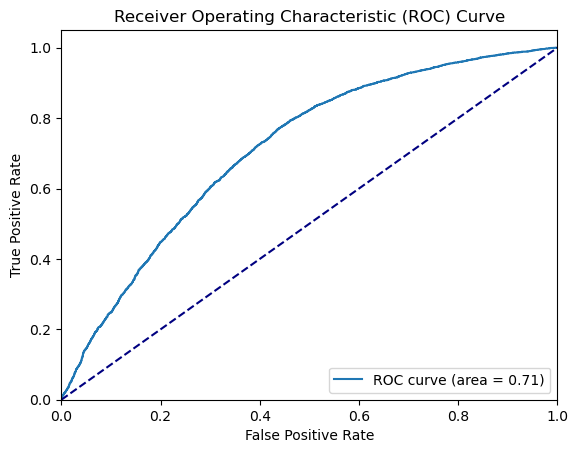

In [7]:
# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()